<a href="https://colab.research.google.com/github/LIVECODING-2025/Saruto/blob/main/Analisis_Sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
!pip install sastrawi
!pip install swifter
!pip install transformers
!pip install wordcloud
!pip install nltk
!pip install joblib

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tqdm import tqdm
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import MarianMTModel, MarianTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from joblib import dump, load

import nltk
import string
import re
import swifter

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
file_id = '/content/drive/MyDrive/Data Science/Live Coding 2025/komentar_berlabel.csv'

In [54]:
df = pd.read_csv(file_id)
print(df.shape)
df.head()

(5997, 2)


,komentar,label
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2
2,NYESEL PILIH PRABOWO,0
3,ekspresinya so iye\npembahasannya walaweee,0
4,Yang komen kenapa parah banget literasinya?mes...,2


Menghapus kolom yang tidak di gunakan

In [ ]:
# Menghapus berdasarkan nama kolom
#df = df.drop(columns=['publish', 'suka', 'author'])
#df.to_csv("komentar_youtub1.csv", index=False)
#print("✅ kolom berhasil di hapus", len(df), "dan disimpan ke 'komentar_youtube1.csv'")

✅ kolom berhasil di hapus 6000 dan disimpan ke 'komentar_youtube1.csv'


In [55]:
df = df.dropna(subset=['label'])  # Hapus baris dengan label NaN

In [56]:
df['label'].unique() #melihat apakah ada kolom yang bernilai nan

array([1, 2, 0])

In [57]:
df.head()

,komentar,label
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2
2,NYESEL PILIH PRABOWO,0
3,ekspresinya so iye\npembahasannya walaweee,0
4,Yang komen kenapa parah banget literasinya?mes...,2


In [58]:
# Mapping angka ke sentimen
label_mapping = {
    0: 'negatif',
    1: 'netral',
    2: 'positif'
}

# Terapkan ke kolom label
df['label_sentiment'] = df['label'].map(label_mapping)

In [59]:
df.head()

,komentar,label,label_sentiment
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif
2,NYESEL PILIH PRABOWO,0,negatif
3,ekspresinya so iye\npembahasannya walaweee,0,negatif
4,Yang komen kenapa parah banget literasinya?mes...,2,positif


Text(0, 0.5, 'Frekuensi')

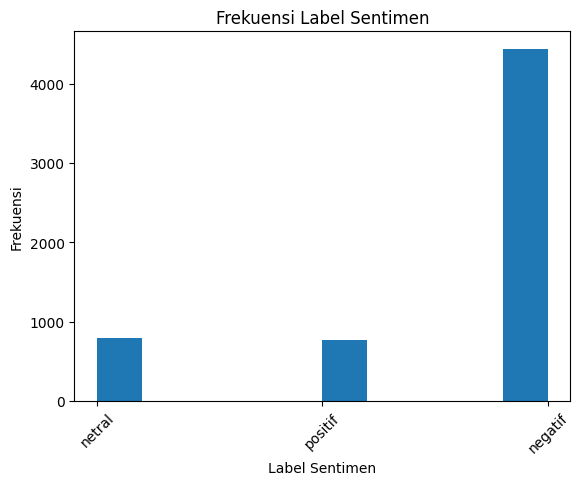

In [60]:
plt.hist(df.label_sentiment)
plt.xticks(rotation=45)
plt.title('Frekuensi Label Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Frekuensi')

# **Pre Procesing**

In [61]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transport & map symbol
        u"\U0001F1E0-\U0001F1FF"  # flags (bendera)
        u"\U00002700-\U000027BF"  # simbol lainnya
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


In [62]:
#Cleansing Data
def cleansing(text):
    text = remove_emoji(text) #hapus emoji
    text = re.sub('\[.*?\]', '', text) #Menghilangkan tanda kurung
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter non-alfabet
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Menghilangkan Tanda Baca
    text = re.sub('\w*\d\w*', '', text) #Menghilangkan Special Karakter
    text = re.sub('\s+[a-zA-Z]\s+', '', text) #Menghilangkan Single Character
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE) #Menghilangkan Link
    text = re.sub(r'\B#\S+','', text)  #Menghilangkan Hashtag
    text = re.sub(r'\s+', ' ', text, flags=re.I) #Mengganti Multiple Spaces ke Single Spaces
    text = text.strip() #Menghilangkan Spaces di awal
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    return text
df['cleansing']= df['komentar'].apply(lambda x: cleansing(x))

In [63]:
df

,komentar,label,label_sentiment,cleansing
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...
...,...,...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1,netral,Petani di desa belum merasakan kebijakan itu p...
5993,Power of vegasus,0,negatif,Power of vegasus
5994,jaka sembung bawa golok,0,negatif,jaka sembung bawa golok
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2,positif,pak tolong lah HAPUS PROGRAM MAKAN GRATIS yg s...


In [64]:
#CaseFolding
def case_folding(text):
    text = text.lower()
    return text
df['casefolding']= df['cleansing'].apply(lambda x: case_folding(x))

In [65]:
df

,komentar,label,label_sentiment,cleansing,casefolding
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,sangat keren meraih kemenangan besar di langsu...
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,memang layak jadi pilihan utama
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,nyesel pilih prabowo
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,ekspresinya so iye pembahasannya walaweee
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,yang komen kenapa parah banget literasinyamesk...
...,...,...,...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1,netral,Petani di desa belum merasakan kebijakan itu p...,petani di desa belum merasakan kebijakan itu p...
5993,Power of vegasus,0,negatif,Power of vegasus,power of vegasus
5994,jaka sembung bawa golok,0,negatif,jaka sembung bawa golok,jaka sembung bawa golok
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2,positif,pak tolong lah HAPUS PROGRAM MAKAN GRATIS yg s...,pak tolong lah hapus program makan gratis yg s...


In [66]:
#Tokenizing
def tokenization(text):
    text = re.split('\W+', text)
    return text
df['tokenizing']= df['casefolding'].apply(lambda x: tokenization(x))

In [67]:
df

,komentar,label,label_sentiment,cleansing,casefolding,tokenizing
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,sangat keren meraih kemenangan besar di langsu...,"[sangat, keren, meraih, kemenangan, besar, di,..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]"
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,nyesel pilih prabowo,"[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,yang komen kenapa parah banget literasinyamesk...,"[yang, komen, kenapa, parah, banget, literasin..."
...,...,...,...,...,...,...
5992,Petani di desa belum merasakan kebijakan itu p...,1,netral,Petani di desa belum merasakan kebijakan itu p...,petani di desa belum merasakan kebijakan itu p...,"[petani, di, desa, belum, merasakan, kebijakan..."
5993,Power of vegasus,0,negatif,Power of vegasus,power of vegasus,"[power, of, vegasus]"
5994,jaka sembung bawa golok,0,negatif,jaka sembung bawa golok,jaka sembung bawa golok,"[jaka, sembung, bawa, golok]"
5995,pak...\ntolong lah HAPUS PROGRAM MAKAN GRATIS ...,2,positif,pak tolong lah HAPUS PROGRAM MAKAN GRATIS yg s...,pak tolong lah hapus program makan gratis yg s...,"[pak, tolong, lah, hapus, program, makan, grat..."


In [68]:
#remove stopword pada list token
def stopwords_removal(words):
    # Define the list of stopwords here
    list_stopwords = ['yang', 'di', 'dan', 'itu', 'dengan', 'atau','untuk', 'dari', 'pada'] # Add your stopwords here
    return [word for word in words if word not in list_stopwords]

df['stop removal']= df['tokenizing'].apply(stopwords_removal)

In [69]:
df.head()

,komentar,label,label_sentiment,cleansing,casefolding,tokenizing,stop removal
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,sangat keren meraih kemenangan besar di langsu...,"[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, lan..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilihan, utama]"
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,yang komen kenapa parah banget literasinyamesk...,"[yang, komen, kenapa, parah, banget, literasin...","[komen, kenapa, parah, banget, literasinyamesk..."


In [70]:
#Stemming
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['stop removal']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['stemming'] = df['stop removal'].apply(get_stemmed_term)
df.head()

Streaming output truncated to the last 5000 lines.
maacam : maacam
persetujuan : tuju
ditingkatkan : tingkat
andalan : andal
terkekang : kekang
longgar : longgar
dibikin : bikin
came : came
ono : ono
teknologinya : teknologi
transformasi : transformasi
perwujutan : perwujutan
ahygibrankang : ahygibrankang
dedibobi : dedibobi
nasution : nasution
inidia : inidia
bagimana : bagimana
dipanggil : panggil
sewaktu : waktu
prabowodi : prabowodi
pupuknya : pupuk
melalu : lalu
ppl : ppl
cod : cod
ptpwtro : ptpwtro
kimia : kimia
grisik : grisik
lansungl : lansungl
kealamat : alamat
pesanan : pesan
ktp : ktp
dibayarr : dibayarr
murid : murid
mister : mister
karn : karn
claim : claim
penyakit : sakit
cba : cba
ambon : ambon
kaco : kaco
dibohongi : bohong
dalang : dalang
coscek : coscek
datanya : data
dibagusbagusin : dibagusbagusin
membingungkan : bingung
genoy : genoy
waspada : waspada
rada : rada
aya : aya
lieuran : lieuran
ieu : ieu
ngabandungana : ngabandungana
oge : oge
putra : putra
oi : oi
i

,komentar,label,label_sentiment,cleansing,casefolding,tokenizing,stop removal,stemming
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,sangat keren meraih kemenangan besar di langsu...,"[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, lan...","[sangat, keren, raih, menang, besar, langsung,..."
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilih, utama]"
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]"
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]"
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,yang komen kenapa parah banget literasinyamesk...,"[yang, komen, kenapa, parah, banget, literasin...","[komen, kenapa, parah, banget, literasinyamesk...","[komen, kenapa, parah, banget, literasinyamesk..."


In [71]:
def normalisasi(document):
  return ' '.join(document)
df['normalisasi'] = df['stemming'].apply(normalisasi)
df.head()

,komentar,label,label_sentiment,cleansing,casefolding,tokenizing,stop removal,stemming,normalisasi
0,Sangat keren! Meraih kemenangan besar di🚦𝐏 𝐋 𝐔...,1,netral,Sangat keren Meraih kemenangan besar di langsu...,sangat keren meraih kemenangan besar di langsu...,"[sangat, keren, meraih, kemenangan, besar, di,...","[sangat, keren, meraih, kemenangan, besar, lan...","[sangat, keren, raih, menang, besar, langsung,...",sangat keren raih menang besar langsung libur ...
1,🔥𝗣 𝗟 𝗨 𝗧 𝗢 𝟴 𝟴 🔥 memang layak jadi pilihan utama,2,positif,memang layak jadi pilihan utama,memang layak jadi pilihan utama,"[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilihan, utama]","[memang, layak, jadi, pilih, utama]",memang layak jadi pilih utama
2,NYESEL PILIH PRABOWO,0,negatif,NYESEL PILIH PRABOWO,nyesel pilih prabowo,"[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]","[nyesel, pilih, prabowo]",nyesel pilih prabowo
3,ekspresinya so iye\npembahasannya walaweee,0,negatif,ekspresinya so iye pembahasannya walaweee,ekspresinya so iye pembahasannya walaweee,"[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresinya, so, iye, pembahasannya, walaweee]","[ekspresi, so, iye, bahas, walaweee]",ekspresi so iye bahas walaweee
4,Yang komen kenapa parah banget literasinya?mes...,2,positif,Yang komen kenapa parah banget literasinyamesk...,yang komen kenapa parah banget literasinyamesk...,"[yang, komen, kenapa, parah, banget, literasin...","[komen, kenapa, parah, banget, literasinyamesk...","[komen, kenapa, parah, banget, literasinyamesk...",komen kenapa parah banget literasinyameski pwo...


In [72]:
#NORMALISASI NEGASI

# Daftar slang dan kata baku
slang_dict = ({
    'bener': 'benar',
    'setuju': 'setuju',
    'cocok': 'sesuai',
    'keren': 'hebat',
    'mantap': 'baik',
    'tepuk tangan': 'apresiasi',
    'oke': 'baik',
    'bagus': 'positif',
    'sukses': 'berhasil',
    'semangat': 'antusias',
    'hebat': 'luar biasa',
    'wajib': 'perlu',
    'top': 'terbaik',
    'gokil': 'hebat',
    'diperjuangkan': 'diperjuangkan',
    'yakin': 'percaya',
    'berharap': 'mengharapkan',
    'nyata': 'terbukti',
    'senang': 'bahagia',
    'maju': 'berkembang',
    'berhasil': 'sukses',
    'sangat setuju': 'setuju sekali',
    'terimakasih': 'terima kasih',
    'berbahagia': 'senang',
    'klop': 'cocok',
    'langsung': 'segera',
    'inovasi': 'perubahan baru',
    'komitmen': 'tanggung jawab',
    'dapat diterima': 'memadai',
    'positif': 'baik',
    'bisa': 'mampu',
    'mendukung': 'mendukung',
    'percaya diri': 'yakin',
    'harapan': 'keinginan',
    'terbaik': 'paling baik',
    'indah': 'bagus',
    'sejahtera': 'makmur',
    'kecewa': 'frustrasi',
    'tidak setuju': 'kurang setuju',
    'masalah': 'permasalahan',
    'kritik': 'komentar',
    'serius': 'penting',
    'bermain politik': 'mengambil langkah politik',
    'korupsi': 'penyalahgunaan',
    'penuh tekanan': 'tertekan',
    'rakyat': 'masyarakat',
    'bangga': 'terhormat',
    'optimis': 'positif',
    'percaya': 'yakin',
    'perhatian': 'peduli',
    'bagus banget': 'sangat baik',
    'sangat penting': 'krusial',
    'belum jelas': 'belum pasti',
    'risih': 'tidak nyaman',
    'menginginkan': 'berharap',
    'realistis': 'dapat diterima',
    'kinerja': 'hasil kerja',
    'politik': 'politik',
    'kompromi': 'penyelesaian',
    'aspirasi': 'keinginan',
    'ke depan': 'untuk masa depan',
    'tidak nyaman': 'kurang menyenangkan',
    'tanggapan': 'respon',
    'perubahan': 'transformasi',
    'progres': 'kemajuan',
    'solusi': 'jawaban',
    'alternatif': 'pilihan',
    'berani': 'tangguh',
    'tegas': 'jelas',
    'harus': 'perlu',
    'rencana': 'strategi',
    'kedepannya': 'di masa depan',
    'bagus lah': 'oke lah',
    'jadi lebih baik': 'makin baik',
    'kerja keras': 'usaha keras',
    'asli': 'benar-benar',
    'selesai': 'tuntas',
    'tanggung jawab': 'amanah',
    'aman': 'terjaga',
    'berat': 'sulit',
    'terlalu lama': 'proses lama',
    'perbaikan': 'peningkatan',
    'menyelesaikan': 'mengakhiri',
    'wajib dilakukan': 'perlu diadakan',
    'baru': 'fresh',
    'terlalu cepat': 'terburu-buru',
    'terlalu lambat': 'terlalu lama',
    'kecewa banget': 'sangat kecewa',
    'kerja sama': 'kolaborasi',
    'apresiasi': 'penghargaan',
    'penurunan': 'kemunduran',
    'kemajuan': 'progres',
    'tindak lanjut': 'lanjutan',
    'transparansi': 'keterbukaan',
    'terus terang': 'jujur',
    'kontroversial': 'perdebatan',
    'bermanfaat': 'berguna',
    'di luar dugaan': 'terkejut',
    'terlalu ambisius': 'terlalu berlebihan',
    'agresif': 'berani',
    'strategis': 'penting',
    'komunikasi': 'interaksi',
    'positif sekali': 'sangat baik',
    'kurang transparan': 'tidak terbuka',
    'mendalam': 'detail',
    'pragmatis': 'praktis',
    'pertumbuhan': 'perkembangan',
    'tidak adil': 'kurang seimbang',
    'berkelanjutan': 'terus-menerus',
    'ideal': 'terbaik',
    'tangguh': 'kuat',
    'berkelanjutan': 'terus menerus',
    'fokus': 'terarah',
    'integritas': 'kejujuran',
    'progresif': 'berkembang',
    'hasil maksimal': 'pencapaian tinggi',
})

    # tambahkan lebih banyak sesuai kebutuhan

# Fungsi normalisasi
def normalize_text(text):
    # Pisahkan teks menjadi kata-kata
    words = text.split()

    # Normalisasi setiap kata
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]

    # Gabungkan kata-kata kembali menjadi satu string
    return ' '.join(normalized_words)

df['normalisasi'] = df['normalisasi'].apply(normalize_text)

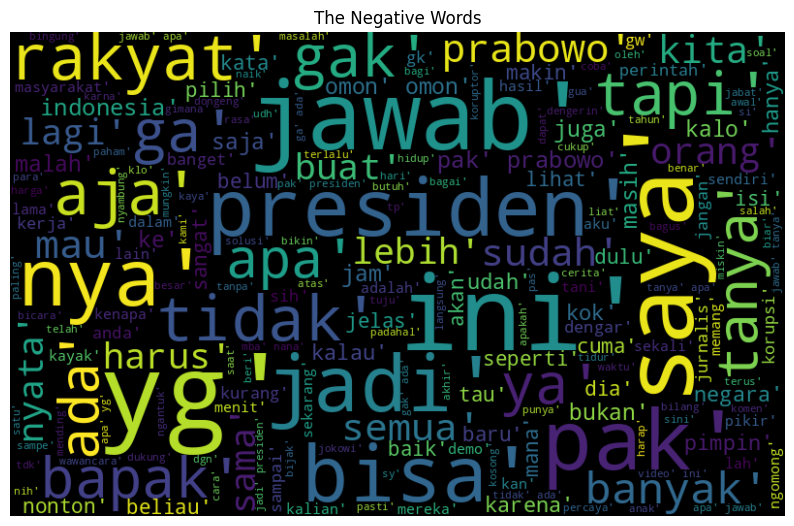

In [88]:
negative_text = df[df['label'] == 0]['stemming'].dropna().astype(str)
negative_text = ' '.join(negative_text)

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

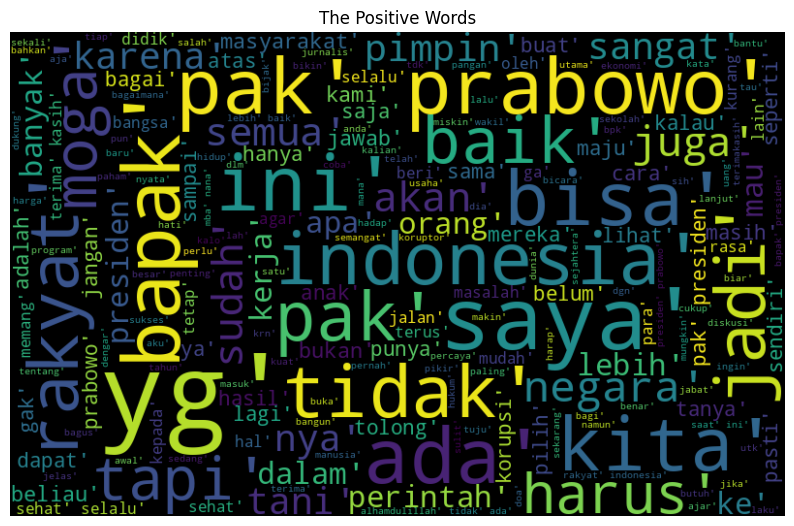

In [89]:
positive_text = df[df['label'] == 2]['stemming'].dropna().astype(str)
positive_text = ' '.join(positive_text)

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(positive_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

In [91]:
X = df['normalisasi']  # Teks hasil preprocessing
y = df['label']        # Label numerik: 0=Negatif, 1=Netral, 2=Positif

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [146]:
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,aa,aaa,aaaaa,aaaaaai,aaaauuuuuu,aaaeetangel,aaai,aah,aahh,aahhhhhh,...,zaman,zamin,zarrah,zatzet,zikir,zn,zong,zonk,zoooonnkkkk,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [246]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [217]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test_tfidf)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.7916666666666666
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88       886
           1       0.68      0.21      0.32       161
           2       0.92      0.30      0.45       153

    accuracy                           0.79      1200
   macro avg       0.80      0.50      0.55      1200
weighted avg       0.79      0.79      0.75      1200



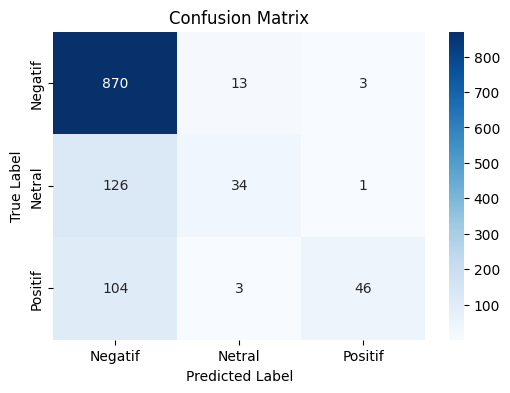

In [108]:
# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

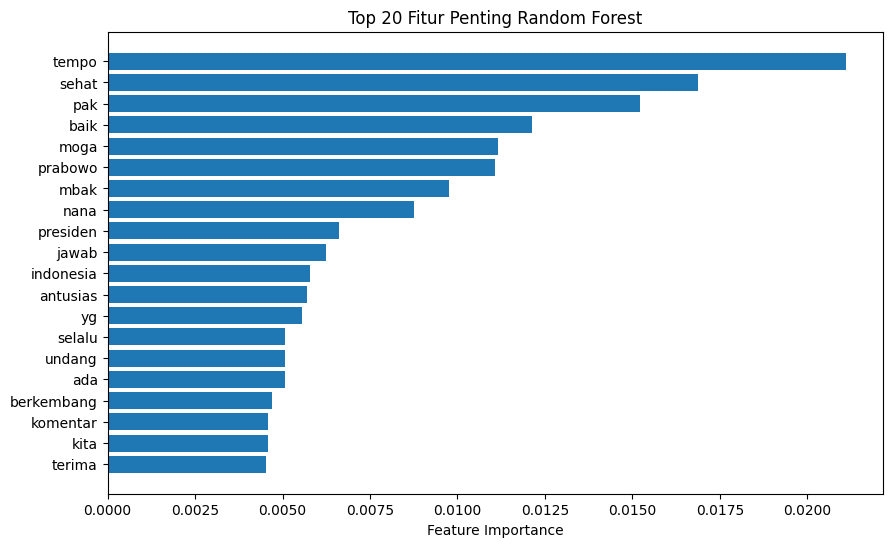

In [105]:
# Ambil importance dari model
importances = model.feature_importances_

# Ambil nama-nama fitur dari TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Urutkan berdasarkan importance terbesar
indices = np.argsort(importances)[-20:]  # Top 20

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Fitur Penting Random Forest')
plt.show()

In [247]:
dump(model, 'random_forest_model.joblib')
dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [248]:
rf = load('random_forest_model.joblib')         # Model Random Forest
tfidf = load('tfidf_vectorizer.joblib')

In [249]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

In [250]:
type(tfidf)

sklearn.feature_extraction.text.TfidfVectorizer